# MNIST


In this project we will be using The MNISt dataset, which is a set of 70,000 small images of digits handwritten by high  school  students  and  employees  of  the  US  Cen‐sus Bureau. Each image is labeled with the digit it represents. This set has been stud‐ied  so  much  that  it  is  often  called  the  “hello  world”  of  Machine  Learning.
</br>
Scikit-Learn provides many helper functions to download popular datasets. MNIST isone of them. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, includ‐ing the following:
- A DESCR key describing the dataset
- A  data  key  containing  an  array  with  one  row  per  instance  and  one  column  perfeature
- A target key containing an array with the labels

In [2]:
X, y = mnist["data"], mnist["target"]

print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each imageis  28  ×  28  pixels,  and  each  feature  simply  represents  one  pixel’s  intensity,  from  0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All we need to do  is  grab  an  instance’s  feature  vector,  reshape  it  to  a  28  ×  28  array,  and  display  it using Matplotlib’s *imshow()* function.

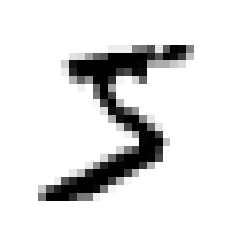

5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print(y[0])

Lets plot some more data.

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

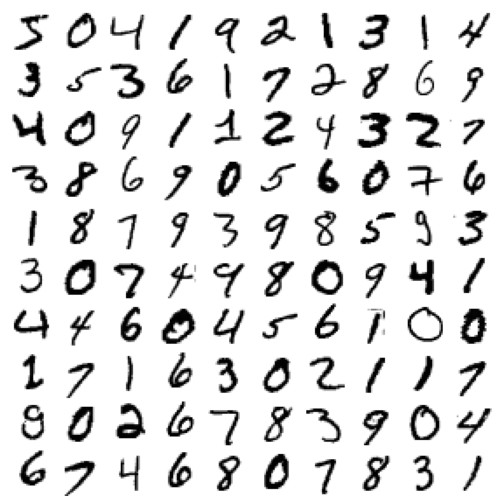

In [6]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

The y label is string, lets change it to integer.

In [7]:
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000images) and a test set (the last 10,000 images).
</br>
The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s  simplify  the  problem  for  now  and  only  try  to  identify  one  digit for  example, the  number  5.  This  “5-detector”  will  be  an  example  of  a  binary  classifier,  capable  of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient  Descent  (SGD)  classifier,  using  Scikit-Learn’s  SGDClassifier  class.  This  classifier has  the  advantage  of  being  capable  of  handling  very  large  datasets  efficiently.  This  is in  part  because  SGD  deals  with  training  instances  independently,  one  at  a  time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5.

In [11]:
sgd_clf.predict([some_digit])

array([ True])

The prediction was indeed right as we have used *some_digit* which is variable with value 5.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will  spend  a  large  part  of  this  chapter  on  this  topic.

### Measuring Accuracy Using Cross-Validation

Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we can implement cross-validation ourself. The   following   code   does   roughly   the   same   thing   as   Scikit-Learns *cross_val_score()* function, and it prints the same result.
</br>
The  *StratifiedKFold*  class  performs  stratified  sampling  (as  explained  in  Chapter  2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions  on  the  test  fold.  Then  it  counts  the  number  of  correct  predictions  and outputs the ratio of correct predictions.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Let’s  use  the  *cross_val_score()* function  to  evaluate  our  *SGDClassifier*  model, using K-fold cross-validation with three folds.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Lets looka at a classifier that just classifies every single image in the "not-5" class.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's find the model's accuracy.

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s  right,  it  has  over  90%  accuracy!  This  is  simply  because  only  about  10%  of  the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
</br>
This demonstrates why accuracy is generally not the preferred performance measure for  classifiers,  especially  when  you  are  dealing  with  skewed  datasets  (i.e.,  when  some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix. To  compute  the  confusion  matrix,  you  first  need  to  have  a  set  of  predictions  so  that they  can  be  compared  to  the  actual  targets.  We  could  make  predictions  on  the  testset,  but  let’s  keep  it  untouched  for  now  (remember  that  we  want  to  use  the  test  set only  at  the  very  end  of  our  project,  once  we  have  a  classifier  that  you  are  ready  to launch). Instead, we can use the *cross_val_predict()* function.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just  like  the  *cross_val_score()*  function,  *cross_val_predict()*  performs  K-foldcross-validation, but instead of returning the evaluation scores, it returns the predictions  made  on  each  test  fold.  This  means  that  we  get  a  clean  prediction  for  each instance  in  the  training  set  (“clean”  meaning  that  the  prediction  is  made  by  a  model that never saw the data during training).
</br>
Now we are ready to get the confusion matrix using the *confusion_matrix()* function. Just pass   it   the   target   classes   (y_train_5)   and   the   predicted   classes(y_train_pred).

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative  class):  53,057  of  them  were  correctly  classified  as  non-5s  (they  are  called  truenegatives),  while  the  remaining  1,522  were  wrongly  classified  as  5s  (false  positives).The  second  row  considers  the  images  of  5s  (the  positive  class):  1,325  were  wronglyclassified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐fied as 5s (true positives). A perfect classifier would have only true positives and truenegatives, so its confusion matrix would have nonzero values only on its main diago‐nal (top left to bottom right)

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

Lets look at the precison and recall of the result.
</br>
precision =TP/(TP+FP) where TP is the number of true positives, and FP is the number of false positives.
</br>
A  trivial  way  to  have  perfect  precision  is  to  make  one  single  positive  prediction  and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named recall, also called sensitivity or the true positive rate(TPR): this is the ratio of positive instances that are correctly detected by the classifier.
</br>
recall = TP/(TP+FN)

FN is, ofcourse, the number of false negatives.

In [19]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print("Precision: ",precision,"Recall: ", recall )

Precision:  0.8370879772350012 Recall:  0.6511713705958311


Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When  it  claims  an  image  represents  a  5,  it  is  correct  only  83.7%  of  the  time.  Moreover, it only detects 65.11% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats  all  values  equally,  the  harmonic  mean  gives  much  more  weight  to  low  values.As a result, the classifier will only get a high F1 score if both recall and precision are high.
<br/>
f1 = 2\*{(precision\*recall)/(precision+recall)}
<br/>
To calculate f1 score we can call *fl_score* fuction

In [20]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.7325171197343846


The F1 score favors classifiers that have similar precision and recall. This is not always what we want: in some contexts we mostly care about precision, and in other contexts we really care about recall. For example, if we trained a classifier to detect videos  that  are  safe  for  kids,  you  would  probably  prefer  a  classifier  that  rejects  many good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐sifier  that  has  a  much  higher  recall  but  lets  a  few  really  bad  videos  show  up  in  your product (in such cases, you may even want to add a human pipeline to check the clas‐sifier’s  video  selection).  On  the  other  hand,  suppose  you  train  a  classifier  to  detect shoplifters  in  surveillance  images:  it  is  probably  fine  if  your  classifier  has  only  30% precision  as  long  as  it  has  99%  recall  (sure,  the  security  guards  will  get  a  few  false alerts, but almost all shoplifters will get caught).Unfortunately,  you  can’t  have  it  both  ways:  increasing  precision  reduces  recall,  and vice versa. This is called the precision/recall trade-off.

## Precision/Recall Trade-off

To understand this trade off, let’s look at how the *SGDClassifier* makes its classification decisions. For each instance, it computes a score based on a decision function. If that  score  is  greater  than  a  threshold,  it  assigns  the  instance  to  the  positive  class; otherwise  it  assigns  it  to  the  negative  class.
<br/>
In this precision/recall trade-off, images are ranked by their classifier score,and those above the chosen decision threshold are considered positive; the higher thethreshold, the lower the recall, but (in general) the higher the precision.
<br/>
Scikit-Learn does not let us set the threshold directly, but it does give you access to the  decision  scores  that  it  uses  to  make  predictions. Instead  of  calling  the  classifier’s *predict()*  method,  we  can  call  its  *decision_function()*  method,  which  returns  a score  for  each  instance,  and  then  use  any  threshold  you  want  to  make  predictions based on those scores.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


The *SGDClassifier* uses a threshold equal to 0, so the previous code returns the samer esult as the *predict()* method (i.e., True). Let’s raise the threshold.

In [22]:
threshold = 80000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


This  confirms  that  raising  the  threshold  decreases  recall.  The  image  actually  represents a 5, and the classifier detects it when the threshold is 0, but it misses it when thethreshold is increased to 8,000.
<br/>
To decide which threshold to use we first, use  the  *cross_val_predict()* function to get the scores of all instances in the training set, but this time specifying that we want to return decision scores instead of predictions.

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

With these scores, use the *precision_recall_curve()* function to compute precision and recall for all possible thresholds.

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, using Matplotlib to plot precision and recall as functions of the threshold value.

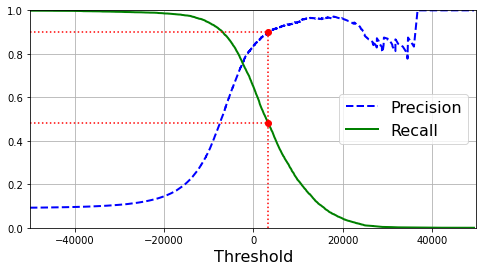

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                             # Not shown
plt.show()

The precision curve is bumpier because precision may sometimes go down  when  we  raise  the  threshold  (although  in  general  it  will  go up). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another  way  to  select  a  good  precision/recall  trade-off  is  to  plot  precision  directlyagainst recall.

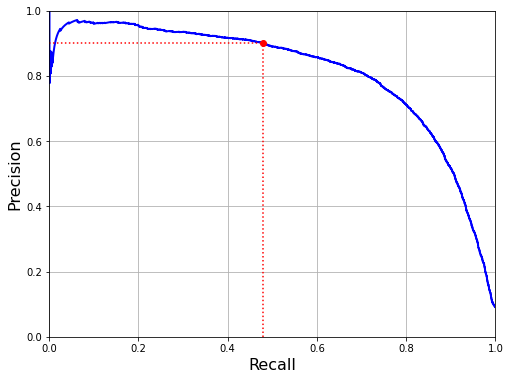

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

We  can  see  that  precision  really  starts  to  fall  sharply  around  80%  recall.  We  will probably  want  to  select  a  precision/recall  trade-off  just  before  that  drop for example, at around 60% recall. But of course, the choice depends on our project. Suppose we decide to aim for 90% precision. We look up the first plot and find that We need to use a threshold of about 8,000. To be more precise we can search for the lowest threshold that gives us at least 90% precision (np.argmax() will give the first index of the maximum value, which in this case means the first True value)

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


To  make  predictions  (on  the  training  set  for  now),  instead  of  calling  the  classifier’s *predict()* method, we can run this code.

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90)

[False False False ...  True False False]


Let’s check these predictions’ precision and recall.

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, we have a 90% precision classifier! As we can see, it is fairly easy to create a classifier with virtually any precision we want: just set a high enough threshold, and we're  done.  But  wait,  not  so  fast.  A  high-precision  classifier  is  not  very  useful  if  its recall is too low.
<br/>
If  someone  says,  “Let’s  reach  99%  precision,”  you  should  ask,  “At what recall?”

## The ROC Curve

The  receiver  operating  characteristic  (ROC)  curve  is  another  common  tool  used  with binary  classifiers.  It  is  very  similar  to  the  precision/recall  curve,  but  instead  of  plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances  that  are  incorrectly  classified  as  positive.  It  is  equal  to  1  –  the  true  negative  rate(TNR), which is the ratio of negative instances that are correctly classified as negative.The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.
<br/>
To  plot  the  ROC  curve,  We  first  use  the  *roc_curve()*  function  to  compute  the  TPR and FPR for various threshold values.

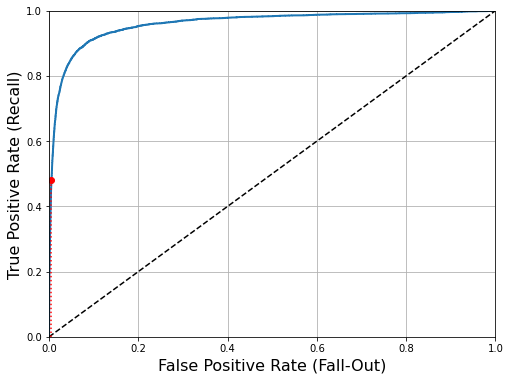

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                  # Not shown
plt.show()
    

Once  again  there  is  a  trade-off:  the  higher  the  recall  (TPR),  the  more  false  positives(FPR)  the  classifier  produces.  The  dotted  line  represents  the  ROC  curve  of  a  purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).


One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROCAUC.

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since  the  ROC  curve  is  so  similar  to  the  precision/recall  (PR)curve, you may wonder how to decide which one to use. As a rule of  thumb,  you  should  prefer  the  PR  curve  whenever  the  positive class  is  rare  or  when  you  care  more  about  the  false  positives  than the  false  negatives.  Otherwise,  use  the  ROC  curve.  For  example, looking at the previous ROC curve (and the ROC AUC score), you may  think  that  the  classifier  is  really  good.  But  this  is  mostly because  there  are  few  positives  (5s)  compared  to  the  negatives(non-5s). In contrast, the PR curve makes it clear that the classifierhas  room  for  improvement  (the  curve  could  be  closer  to  the  top-left corner)

Let’s  now  train  a  *RandomForestClassifier*  and  compare  its  ROC  curve  and  ROCAUC  score  to  those  of  the  SGDClassifier.  First,  you  need  to  get  scores  for  each instance  in  the  training  set.  But  due  to  the  way  it  works, the  *RandomForestClassifier*  class  does  not  have  a  *decision_function()*  method.  Instead, it Classification
has  a  *predict_proba()*  method.  Scikit-Learn  classifiers  generally  have  one  or  the other,  or  both.  The  *predict_proba()*  method  returns  an  array  containing  a  row  perinstance  and  a  column  per  class,  each  containing  the  probability  that  the  giveninstance belongs to the given class (e.g., 70% chance that the image represents a 5).

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

The  *roc_curve()* function  expects  labels  and  scores,  but  instead  of  scores  we  can give it class probabilities. Let’s use the positive class’s probability as the score.

In [34]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

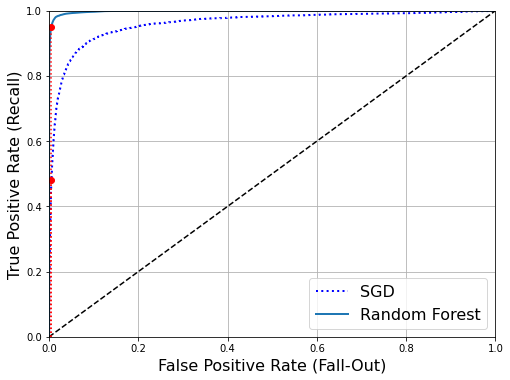

In [35]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

The RandomForestClassifier’s ROC curve looks much better  than  the  SGDClassifier’s:  it  comes  much  closer  to  the  top-left  corner.  As  a result, its ROC AUC score is also significantly better.

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Finally, let's print the accuracy and precision.

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [38]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

we now know how to train binary classifiers, choose the appropriate metric for our task, evaluate our classifiers using cross-validation, select the precision/recall trade-off that fits our needs, and use ROC curves and ROC AUC scores to compare vari‐ous models. Now let’s try to detect more than just the 5s.

## Multiclass Classification

Whereas  binary  classifiers  distinguish  between  two  classes,  multiclass classifiers  (also called multinomial classifiers) can distinguish between more than two classes. Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers)  are  capable  of  handling  multiple  classes  natively.  Others  (such  as  LogisticRegression or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classificationwith multiple binary classifiers. One way to create a system that can classify the digit images into 10 classes (from 0 to 9)  is  to  train  10  binary  classifiers,  one  for  each  digit  (a  0-detector,  a  1-detector,  a  2-detector, and so on). Then when we want to classify an image, we get the decision score from each classifier for that image and we select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also calledone-versus-all). Another  strategy  is  to  train  a  binary  classifier  for  every  pair  of  digits:  one  to  distinguish  0s  and  1s,  another  to  distinguish  0s  and  2s,  another  for  1s  and  2s,  and  so  on. This  is  called  the  one-versus-one  (OvO)  strategy.  If  there  are  N  classes,  we  need  totrain  N  ×  (N  –  1)  /  2  classifiers.  For  the  MNIST  problem,  this  means  training  45 binary  classifiers!  When  we  want  to  classify  an  image,  we  have  to  run  the  image through  all  45  classifiers  and  see  which  class  wins  the  most  duels.  The  main  advantage of OvO is that each classifier only needs to be trained on the part of the trainingset for the two classes that it must distinguish. Some  algorithms  (such  as  Support  Vector  Machine  classifiers)  scale  poorly  with  the size  of  the  training  set.  For  these  algorithms  OvO  is  preferred  because  it  is  faster  to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when we try to use a binary classification algorithm for a multi‐class  classification  task,  and  it  automatically  runs  OvR  or  OvO,  depending  on  the algorithm.  Let’s  try  this  with  a  Support  Vector  Machine  classifier, using the *sklearn.svm.SVC* class:

In [39]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

That  was  easy!  This  code  trains  the  SVC  on  the  training  set  using  the  original  target classes   from   0   to   9   (y_train),   instead   of   the   5-versus-the-rest   target   classes(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.If  we  call  the  *decision_function()*  method,  we  will  see  that  it  returns  10  scores per instance (instead of just 1). That’s one score per class.

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

When  a  classifier  is  trained,  it  stores  the  list  of  target  classes  in  its *classes_* attribute, ordered by value. In this case, the index of each class  in  the  *classes_*  array  conveniently  matches  the  class  itself (e.g., the class at index 5 happens to be class 5), but in general we won’t be so lucky.

If  we  want  to  force  Scikit-Learn  to  use  one-versus-one  or  one-versus-the-rest,  we can  use  the  *OneVsOneClassifier*  or  *OneVsRestClassifier*  classes.  Simply  create  an instance  and  pass  a  classifier  to  its  constructor  (it  does  not  even  have  to  be  a  binaryclassifier).  For  example,  this  code  creates  a  multiclass  classifier  using  the  OvR  strat‐egy, based on an SVC:
<br/>
**!!! The code below will take very long time to compute so they are commented out but can be executed whenever necessary (only a small sample is taken for faster exection**

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:100], y_train[:100])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [48]:
ovr_clf.predict([some_digit])


array([5], dtype=uint8)

In [49]:
len(ovr_clf.estimators_)

10

Training an *SGDClassifier* (or a RandomForestClassifier) is just as easy.

In [56]:
sgd_clf.fit(X_train[:100], y_train[:100])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers candirectly  classify  instances  into  multiple  classes.  The  decision_function()  methodnow returns one value per class. Let’s look at the score that the SGD classifier assignedto each class.

In [57]:
sgd_clf.decision_function([some_digit])

array([[-20722091.53681121, -18169387.23610712, -15721140.16708742,
         -1092999.6438692 , -39289471.34882002,   6294279.54476251,
         -3878406.8911707 , -24314511.98221525, -14573277.07882209,
        -23894139.33910285]])

We can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of 2412.5. The model has a slight doubtregarding class 3, which gets a score of 573.5. Now of course we want to evaluate this classifier.  As  usual,  we  can  use  cross-validation.  Use  the  *cross_val_score()*  function to evaluate the SGDClassifier’s accuracy. **Only a sample of the data is taken so the values int this paragraph may differ with the output.**

In [59]:
cross_val_score(sgd_clf, X_train[:100], y_train[:100], cv=3, scoring="accuracy")


array([0.73529412, 0.75757576, 0.84848485])

It gets over 84% on all test folds. If we used a random classifier, we would get 10% accuracy, so this is not such a bad score, but we can still do much better. Simply scaling the input increases accuracy above 89%.

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:100], y_train[:100], cv=3, scoring="accuracy")

array([0.70588235, 0.66666667, 0.81818182])

## Error Analysis

We will explore  data  preparation  options,  try out multiple  models  (shortlisting  the  best  ones  and  fine-tuning  their  hyperparametersusing  GridSearchCV),  and  automate  as  much  as  possible.  Here,  we  will  assume  that we have found a promising model and we want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First,   look   at   the   confusion   matrix.   We   need   to   make   predictions   using   the *cross_val_predict()* function, then call the *confusion_matrix()* function, just like we did earlier.

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:100], y_train[:100], cv=3)
conf_mx = confusion_matrix(y_train[:100], y_train_pred)
conf_mx

array([[11,  0,  1,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  4,  2,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  8,  1,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  1,  5,  2,  0,  1,  0,  1],
       [ 0,  0,  0,  2,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  0,  8,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  3,  1,  5]])

That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s *matshow()* function.

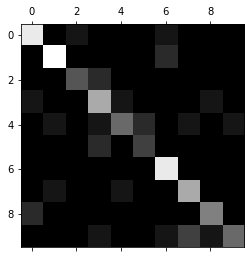

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This  confusion  matrix  looks  pretty  good,  since  most  images  are  on  the  main  diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that  the  classifier  does  not  perform  as  well  on  5s  as  on  other  digits.  In  fact,  we  can verify that both are the case. Let’s focus the plot on the errors. First, we need to divide each value in the confusionmatrix by the number of images in the corresponding class so that we can compare error  rates  instead  of  absolute  numbers  of  errors  (which  would  make  abundant classes look unfairly bad).

In [71]:
row_sums = conf_mx.sum(axis=0, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result.

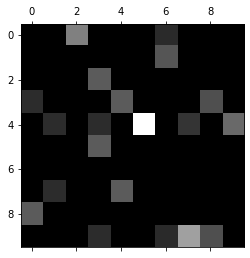

In [82]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 3  is  quite  bright,  which  tells  us  that  many  images  get  misclassified  as  3s.  However,the  row  for  class  6  is  not  that  bad,  telling  us  that  actual  6s  in  general  get  properlyclassified  as  6s.  As  we  can  see,  the  confusion  matrix  is  not  necessarily  symmetrical. We can also see that 3s and 4s often get confused (in both directions).

Analyzing  individual  errors  can  also  be  a  good  way  to  gain  insights  on  what  our classifier  is  doing  and  why  it  is  failing,  but  it  is  more  difficult  and  time-consuming. 

## Multilabel Classification